# Reinforcement Learning (PPO)

## Task Definition (Atari Assault)

The agent has to decide to choose an action in a space of 7 discrete space, which gives 18 possible actions. The observation state is RGB images of shape = (250, 160, 3) with integer values between [0-255]. 

You can learn more about it here:
https://gymnasium.farama.org/environments/atari/assault/

In this Notebook, we are going to experiment with two version of Q learning: (A) Deep Q Network and (B) PPO. 


In [1]:
import gymnasium as gym
import math
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#This is the environment or game to be used with rgb output (from render)
env = gym.make("ALE/Assault-v5", render_mode='rgb_array')

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

total_n_episodes = 1000

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [2]:
#Track episode duration when training / evaluating 
#Note: The total reward in this env represent the duration of an episode, which sometimes can be different.

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration / Total Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    #The state 

    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=3)
        self.cnn2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=3)
        self.pool = nn.MaxPool2d(3, stride=2)
        self.cnn3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4480, 256)
        self.fc2 = nn.Linear(256, n_actions)

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = F.relu(self.cnn1(x))
        x = F.relu(self.cnn2(x))
        x = F.relu(self.cnn3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [5]:
#Preprocess the frames by switching axes and normalizing values to floats
#Input frames should be passed in a batch mode (batch, 3, h, w)
def prepare_frame(state):
    
    #Create a float tensor
    state = torch.tensor(np.numpy([state]), dtype=torch.float32)
    #Permute shape from (batch, h, w, 3) to (batch, 3, h, w)
    state = torch.permute(state, (0, 3, 1, 2))
    #Normalize values to obtain floats
    state = state / 255.

    return state 

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

#Track the duration of the epipsodes
episode_durations = []

policy_net = DQN(n_actions).to(device)

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = policy_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [8]:
# Function to render and display the environment
def display_environment(env, policy_net):
    state, _ = env.reset()
    plt.figure()

    img = plt.imshow(env.render())  # Initialize the rendering with an empty frame
    
    done = False

    for t in range(1000):  # Run for a set number of time steps

        state = prepare_frame(state)
        action = policy_net(state).argmax().item()  # Select action
        state, reward, terminated, truncated, _ = env.step(action)  # Take a step
        
        done = terminated or truncated
        
        frame = env.render()  # Render the environment to an RGB array
        img.set_data(frame)  # Update the rendering
        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
        time.sleep(0.01)  # Pause to slow down the rendering

        if done:
            print("Game over..Your agent sucks!")
            break
    
    if not done:
        print("Game over..Your agent is great!")

env.close()


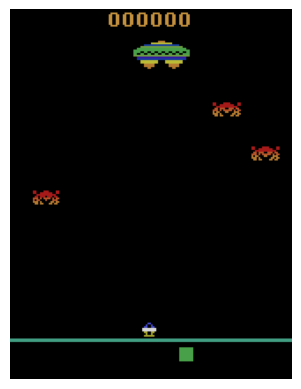

Game over..Your agent sucks!


: 

In [163]:
# Assuming you have your policy network and environment initialized
display_environment(env, policy_net)

In [9]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 2000
else:
    num_episodes = 100

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = prepare_frame(state)

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = prepare_frame(observation)
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        if done:
            episode_durations.append(t + 1)
            if(t % 10 == 0):
                plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

C:\Users\fares\AppData\Local\Temp\ipykernel_10620\273173432.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  state = torch.tensor([state], dtype=torch.float32)


: 

In [ ]:
# Assuming you have your policy network and environment initialized
display_environment(env, policy_net)